In [124]:
import numpy as np
import pandas as pd
import catboost
import time

from catboost import Pool, sum_models
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

In [125]:
VERSION = round(time.time())

In [126]:
df_train_set = pd.read_csv('data/trainingValues.csv', index_col='id')
df_train_labels = pd.read_csv('data/trainingLabels.csv', index_col='id')

df_test = pd.read_csv('data/testValues.csv', index_col='id')

In [127]:
np.testing.assert_array_equal(df_train_set.index.values, df_train_labels.index.values)

In [128]:
joined_df = df_train_set.join(df_train_labels)

In [129]:
def clean_installer(df):

    df['installer'] = df['installer'].astype(str).str.lower()
    df['installer'].replace(
        to_replace=(
            'fini water', 'fin water', 'finn water', 'finwater', 'finwate'),
        value='finw', inplace=True)
    df['installer'].replace(to_replace=('jaica co'), value='jaica', inplace=True)
    df['installer'].replace(
        to_replace=(
            'district water department', 'district water depar', 'district council',
            'district counci', 'village council orpha','kibaha town council',
            'village council', 'coun', 'village counil', 'council',
            'mbulu district council', 'counc', 'village council .oda',
            'sangea district coun', 'songea district coun', 'villege council',
            'district  council', 'quick win project /council', 'mbozi district council',
            'village  council', 'municipal council', 'tabora municipal council',
            'wb / district council'),
        value='council', inplace=True)
    df['installer'].replace(
        to_replace=(
            'rc church', 'rc churc', 'rcchurch/cefa', 'irc', 'rc', 'rc ch', 'hw/rc',
            'rc church/central gover', 'kkkt church', 'pentecost church', 'roman church',
            'rc/mission', 'rc church/cefa', 'lutheran church', 'tag church',
            'free pentecoste church of tanz', 'rc c', 'church', 'rc cathoric',
            'morovian church', 'cefa/rc church', 'rc mission', 'anglican church',
            'church of disciples', 'anglikana church', 'cetral government /rc',
            'pentecostal church', 'cg/rc', 'rc missionary', 'sda church', 'methodist church', 'trc',
            'rc msufi', 'haidomu lutheran church', 'baptist church', 'rc church brother',
            'st magreth church', 'anglica church', 'global resource co', 'rc mi',
            'baptist church of tanzania', 'fpct church', 'rc njoro', 'rc .church',
            'rc mis', 'batist church', 'churc', 'dwe/anglican church','missi', 'mission',
            'ndanda missions', 'rc/mission', 'cvs miss', 'missionaries', 'hydom luthelani',
            'luthe', 'haydom lutheran hospital', 'lutheran', 'missio', 'germany missionary',
            'grail mission kiseki bar', 'missionary', 'heri mission', 'german missionsry',
            'wamissionari wa kikatoriki', 'neemia mission', 'wamisionari wa kikatoriki'),
        value='church', inplace=True)
    df['installer'].replace(
        to_replace=(
            'central government', 'gove', 'central govt', 'gover', 'cipro/government',
            'governme', 'adra /government', 'isf/government', 'adra/government',
            'government /tcrs', 'village govt', 'government', 'government /community',
            'concern /government', 'goverm', 'village government', 'cental government',
            'govern', 'cebtral government', 'government /sda', 'tcrs /government',
            'tanzania government', 'centra govt', 'colonial government', 'misri government',
            'government and community', 'cetral government /rc', 'concern/government',
            'government of misri', 'lwi &central government', 'governmen', 'government/tcrs', 'government /world vision',
            'centra government'),
        value='tanzanian government', inplace=True)
    df['installer'].replace(
        to_replace=(
            'world vission', 'world division', 'word divisio','world visiin'),
        value='world vision', inplace=True)
    df['installer'].replace(to_replace=('unicrf'), value='unicef', inplace=True)
    df['installer'].replace(
        to_replace=(
            'commu', 'olgilai village community', 'adra /community', 'adra/community',
            'rwe/ community', 'killflora /community', 'communit', 'taboma/community',
            'arab community', 'adra/ community', 'sekei village community', 'rwe/community',
            'arabs community', 'village community', 'government /community',
            'dads/village community', 'killflora/ community', 'mtuwasa and community',
            'rwe /community', 'ilwilo community', 'summit for water/community',
            'igolola community', 'ngiresi village community', 'rwe community',
            'african realief committe of ku', 'twesa /community', 'shelisheli commission',
            'twesa/ community', 'marumbo community', 'government and community',
            'community bank', 'kitiangare village community', 'oldadai village community',
            'twesa/community', 'tlc/community', 'maseka community', 'islamic community',
            'district community j', 'village water commission', 'village community members',
            'tcrs/village community', 'village water committee', 'comunity'),
        value='community', inplace=True)
    df['installer'].replace(
        to_replace=(
            'danid', 'danda','danida co', 'danny', 'daniad', 'dannida', 'danids'),
        value='danida', inplace=True)
    df['installer'].replace(
        to_replace=(
            'hesaws', 'huches', 'hesaw', 'hesawz', 'hesawq', 'hesewa'),
        value='hesawa', inplace=True)
    df['installer'].replace(
        to_replace=(
            'dwsp', 'kkkt _ konde and dwe', 'rwe/dwe', 'rwedwe', 'dwe/', 'dw', 'dwr',
            'dwe}', 'dwt', 'dwe /tassaf', 'dwe/ubalozi wa marekani', 'consultant and dwe',
            'dwe & lwi', 'ubalozi wa marekani /dwe', 'dwe&', 'dwe/tassaf', 'dw$',
            'dw e', 'tcrs/dwe', 'dw#', 'dweb', 'tcrs /dwe', 'water aid/dwe', 'dww'),
        value='dwe', inplace=True)
    df['installer'].replace(
        to_replace=(
            'africa muslim', 'muslimu society(shia)', 'africa muslim agenc',
            'african muslims age', 'muslimehefen international','islamic',
            'the isla', 'islamic agency tanzania',  'islam', 'nyabibuye islamic center'),
        value='muslims', inplace=True)
    df['installer'].replace(
        to_replace=(
            'british colonial government', 'british government', 'britain'),
        value='british', inplace=True)
    df['installer'].replace(
        to_replace=(
            'tcrs/tlc', 'tcrs /care', 'cipro/care/tcrs', 'tcrs kibondo', 'tcrs.tlc',
            'tcrs /twesa', 'tassaf /tcrs', 'tcrs/care', 'tcrs twesa', 'rwe/tcrs',
            'tcrs/twesa', 'tassaf/ tcrs', 'tcrs/ tassaf', 'tcrs/ twesa', 'tcrs a',
            'tassaf/tcrs'),
        value='tcrs', inplace=True)
    df['installer'].replace(
        to_replace=(
            'kkkt-dioces ya pare', 'kkkt leguruki', 'kkkt ndrumangeni', 'kkkt dme',
            'kkkt kilinga', 'kkkt canal', 'kkkt katiti juu', 'kkkt mareu'),
        value='kkkt', inplace=True)
    df['installer'].replace(to_replace=('norad/'), value='norad', inplace=True)
    df['installer'].replace( to_replace=('tasaf/dmdd', 'dmdd/solider'),
        value='dmdd', inplace=True)
    df['installer'].replace(
        to_replace=('cjejow construction', 'cjej0'), value='cjejow', inplace=True)
    df['installer'].replace(
        to_replace=(
            'china henan constuction', 'china henan contractor', 'china co.', 'chinese'),
        value='china', inplace=True)
    df['installer'].replace(
        to_replace=(
            'local contract', 'local technician', 'local', 'local  technician',
            'locall technician', 'local te', 'local technitian', 'local technical tec',
            'local fundi', 'local technical', 'localtechnician', 'village local contractor',
            'local l technician'),
        value='local', inplace=True)
    df['installer'].replace(
        to_replace=(
            'oikos e .africa', 'oikos e.africa', 'africa amini alama',
            'africa islamic agency tanzania', 'africare', 'african development foundation',
            'oikos e. africa', 'oikos e.afrika', 'afroz ismail', 'africa', 'farm-africa',
            'oikos e africa', 'farm africa', 'africaone', 'tina/africare', 'africaone ltd',
            'african reflections foundation', 'africa m'),
        value='africa', inplace=True)
    df['installer'].replace(to_replace=('0', 'nan', '-'), value='other', inplace=True)
    df_installer_cnt = df.groupby('installer')['installer'].count()
    other_list = df_installer_cnt[df_installer_cnt<71].index.tolist()
    df['installer'].replace(to_replace=other_list, value='other', inplace=True)

In [130]:
def clean_funder(df):
    
    df['funder'] = df['funder'].astype(str).str.lower()
    df['funder'].replace(
        to_replace=(
            'kkkt_makwale', 'kkkt-dioces ya pare', 'world vision/ kkkt', 'kkkt church',
            'kkkt leguruki', 'kkkt ndrumangeni', 'kkkt dme', 'kkkt canal', 'kkkt usa',
            'kkkt mareu'),
        value='kkkt', inplace=True)
    df['funder'].replace(
        to_replace=(
            'government of tanzania', 'norad /government', 'government/ community',
            'cipro/government', 'isf/government', 'finidagermantanzania govt',
            'government /tassaf', 'finida german tanzania govt', 'village government',
            'tcrs /government', 'village govt', 'government/ world bank',
            'danida /government', 'dhv/gove', 'concern /govern', 'vgovernment',
            'lwi & central government', 'government /sda', 'koica and tanzania government',
            'world bank/government', 'colonial government', 'misri government',
            'government and community', 'concern/governm', 'government of misri',
            'government/tassaf', 'government/school', 'government/tcrs', 'unhcr/government',
            'government /world vision', 'norad/government'),
        value='government', inplace=True)
    df['funder'].replace(
        to_replace=(
            'british colonial government', 'japan government', 'china government',
            'finland government', 'belgian government', 'italy government',
            'irish government', 'egypt government', 'iran gover', 'swedish', 'finland'),
        value='foreign government', inplace=True)
    df['funder'].replace(
        to_replace=(
            'rc church', 'anglican church', 'rc churc', 'rc ch', 'rcchurch/cefa',
            'irc', 'rc', 'churc', 'hw/rc', 'rc church/centr', 'pentecosta church',
            'roman church', 'rc/mission', "ju-sarang church' and bugango",
            'lutheran church', 'roman cathoric church', 'tag church ub', 'aic church',
            'free pentecoste church of tanz', 'tag church', 'fpct church', 'rc cathoric',
            'baptist church', 'morovian church', 'cefa/rcchurch', 'rc mission',
            'bukwang church saints', 'agt church', 'church of disciples', 'rc mofu',
            "gil cafe'church'", 'pentecostal church', 'bukwang church saint',
            'eung am methodist church', 'rc/dwe', 'cg/rc', 'eung-am methodist church',
            'rc missionary', 'sda church', 'methodist church', 'rc msufi',
            'haidomu lutheran church', 'nazareth church', 'st magreth church',
            'agape churc', 'rc missi', 'rc mi', 'rc njoro', 'world vision/rc church',
            'pag church', 'batist church', 'full gospel church', 'nazalet church',
            'dwe/anglican church', 'missi', 'mission', 'missionaries', 'cpps mission',
            'cvs miss', 'grail mission kiseki bar', 'shelisheli commission', 'missionary',
            'heri mission', 'german missionary', 'wamissionari wa kikatoriki',
            'rc missionary', 'germany missionary', 'missio', 'neemia mission', 'rc missi',
            'hydom luthelani', 'luthe', 'lutheran church',  'haydom lutheran hospital',
            'village council/ haydom luther', 'lutheran', 'haidomu lutheran church',
            'resolute golden pride project', 'resolute mininggolden pride',
            'germany cristians'),
        value='church', inplace=True)
    df['funder'].replace(
        to_replace=(
            'olgilai village community', 'commu', 'community', 'arab community',
            'sekei village community', 'arabs community', 'village community',
            'mtuwasa and community', 'ilwilo community', 'igolola community',
            'ngiresi village community', 'marumbo community', 'village communi',
            'comune di roma', 'comunity construction fund', 'community bank',
            "oak'zion' and bugango b' commu", 'kitiangare village community',
            'oldadai village community', 'tlc/community', 'maseka community',
            'islamic community',  'tcrs/village community', 'buluga subvillage community',
            'okutu village community'),
        value='community', inplace=True)
    df['funder'].replace(
        to_replace=(
            'council', 'wb / district council', 'cdtfdistrict council',
            'sangea district council', 'mheza distric counc', 'kyela council',
            'kibaha town council', 'swidish', 'mbozi district council', 
            'village council/ rose kawala',  'songea municipal counci',
            'quick win project /council', 'village council', 'villege council',
            'tabora municipal council', 'kilindi district co', 'kigoma municipal council',
            'district council', 'municipal council', 'district medical',
            'sengerema district council', 'town council', 'mkinga  distric cou',
            'songea district council', 'district rural project', 'mkinga distric coun',
            'dadis'),
        value='district', inplace=True)
    df['funder'].replace(
        to_replace=(
            'tcrs.tlc', 'tcrs /care', 'tcrst', 'cipro/care/tcrs', 'tcrs/care', 'tcrs kibondo'),
        value='tcrs', inplace=True)
    df['funder'].replace(
        to_replace=(
            'fini water', 'finw', 'fin water', 'finn water', 'finwater'),
        value='fini', inplace=True)
    df['funder'].replace(
        to_replace=(
            'islamic', 'the isla', 'islamic found', 'islamic agency tanzania',
            'islam', 'muislam', 'the islamic', 'nyabibuye islamic center', 'islamic society', 'african muslim agency',
            'muslims', 'answeer muslim grou', 'muslimu society(shia)',
            'unicef/african muslim agency', 'muslim world', 'muslimehefen international',
            'shear muslim', 'muslim society'),
        value='islam', inplace=True)
    df['funder'].replace(
        to_replace=('danida', 'ms-danish', 'unhcr/danida', 'tassaf/ danida'),
        value='danida', inplace=True)
    df['funder'].replace(
        to_replace=(
            'hesawa', 'hesawz', 'hesaw', 'hhesawa', 'hesawwa', 'hesawza', 'hesswa',
            'hesawa and concern world wide'),
        value='hesawa', inplace=True)
    df['funder'].replace(
        to_replace=('world vision/adra', 'game division', 'worldvision'),
        value='world vision', inplace=True)
    df['funder'].replace(
        to_replace=(
            'germany republi', 'a/co germany', 'aco/germany', 'bingo foundation germany',
            'africa project ev germany', 'tree ways german'),
        value='germany', inplace=True)
    df['funder'].replace(to_replace=('0', 'nan', '-'), value='other', inplace=True)
    df_funder_cnt = df.groupby('funder')['funder'].count()
    other_list = df_funder_cnt[df_funder_cnt<98].index.tolist()
    df['funder'].replace(to_replace=other_list, value='other', inplace=True)    

In [131]:
def get_medians_df(df):
    
    df_geo = df.groupby(['region_code'])[['latitude', 'longitude']].median()
    df_subvillage = df.groupby(['region_code'])['subvillage'].agg(pd.Series.mode)
    df_scheme = df.groupby(['region'])['scheme_name'].agg(pd.Series.mode)
    return df_geo, df_subvillage, df_scheme
    
    
def geo_restore(df, df_geo):
    
    def geo_update(row, df_geo):
        row['longitude'] = df_geo.loc[row['region_code']]['longitude']
        row['latitude'] = df_geo.loc[row['region_code']]['latitude']
        return row

    df.loc[df['longitude']==0, ['longitude', 'latitude']] = \
        df[df['longitude']==0].apply(
            geo_update, df_geo=df_geo, axis=1)[['longitude', 'latitude']]
    
    
def scheme_restore(df, df_scheme):
    
    def scheme_update(row, df_scheme):
        row['scheme_name'] = df_scheme[row['region']]
        return row

    df.loc[df['scheme_name'].isnull(), ['scheme_name']] = \
        df[df['scheme_name'].isnull()].apply(
            scheme_update, df_scheme=df_scheme, axis=1)[['scheme_name']]
    
    
def subvillage_restore(df, df_subvillage):

    def subvillage_update(row, df_subvillage):
        row['subvillage'] = df_subvillage[row['region_code']]
        return row

    df.loc[df['subvillage'].isnull(), ['subvillage']] = \
        df[df['subvillage'].isnull()].apply(
            subvillage_update, df_subvillage=df_subvillage, axis=1)[['subvillage']]
    
    
def get_medians(df):
    
    df_pm_median = df['public_meeting'].median()
    df_permit_median = df['permit'].median()
    return df_pm_median, df_permit_median
    
    
def fill_na(df, df_pm_median, df_permit_median):
    
    df.loc[df['public_meeting'].isnull(), 'public_meeting'] = df_pm_median
    df.loc[df['permit'].isnull(), 'permit'] = df_permit_median
    
    
def create_na_features(df):    
    
    na_cols = ['subvillage', 'public_meeting', 'scheme_name', 'permit']
    for c in na_cols:
        df[f'c_na'] = df[c].isnull()  


In [132]:
def drop(df):
    
    df.drop([
        'scheme_management', 
        # 'quantity_group', 'water_quality', 
        'region_code', 
        'payment_type',
        # 'extraction_type', 
        # 'waterpoint_type_group', 
        'date_recorded', 'recorded_by',
        ],
        axis=1, inplace=True)


In [133]:
df_train = df_train_set.join(df_train_labels)
clean_installer(df_train)
clean_funder(df_train)
df_geo, df_subvillage, df_scheme = get_medians_df(df_train)
# geo_restore(df_train, df_geo)
subvillage_restore(df_train, df_subvillage)
scheme_restore(df_train, df_scheme)
create_na_features(df_train)
df_pm_median, df_permit_median = get_medians(df_train)
fill_na(df_train, df_pm_median, df_permit_median)
drop(df_train)

clean_installer(df_test)
clean_funder(df_test)
# geo_restore(df_test, df_geo)
subvillage_restore(df_test, df_subvillage)
scheme_restore(df_test, df_scheme)
create_na_features(df_test)
fill_na(df_test, df_pm_median, df_permit_median)
drop(df_test)

In [134]:
df_train.nunique()

amount_tsh                  98
funder                      84
gps_height                2428
installer                   83
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoi

In [135]:
def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(
        max_ctr_complexity=5,
        task_type='GPU',
        iterations=10000,
        eval_metric='AUC',
        od_type='Iter',
        loss_function='MultiClass',
        one_hot_max_size=6,
        od_wait=500,
        classes_count=3,
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=1000,
        plot=False,
        use_best_model=True)

In [136]:
num_cols = [
    'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
    'district_code', 'population'
]
cat_features = [x for x in df_train.columns if x not in num_cols and x!='status_group']
df_train[cat_features] = df_train[cat_features].astype('category')
df_test[cat_features] = df_test[cat_features].astype('category')

In [137]:
def classification_rate(y, y_pred):
    return np.sum(y==y_pred)/len(y)

In [138]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['status_group'], axis=1), df_train['status_group'], test_size=0.3, random_state=1)

# y_train, X_train = df_train['status_group'], df_train.drop(['status_group'], axis=1)

In [139]:
categorical_features_indices = np.where(X_train.dtypes != float)[0]

In [140]:
model = CatBoostClassifier(
    max_ctr_complexity=5,
    task_type='GPU',
    iterations=10000,
    eval_metric='AUC',
    od_type='Iter',
    loss_function='MultiClass',
    # one_hot_max_size=6,
    od_wait=1000,
    cat_features=cat_features,
    learning_rate=0.1,
    l2_leaf_reg=1,
    depth=6
    # classes_count=3
)

model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        cat_features=cat_features,
        verbose=1000,
        plot=False,
        use_best_model=True
        )

# grid = {
#     'depth': [6, 10]
# }

# grid_search_result = model.grid_search(grid,
#                                        X=df_train.drop(
#                                            ['status_group'], axis=1),
#                                        y=df_train['status_group'],
#                                        cv=5,
#                                        stratified=True,
#                                        plot=True
#                                        )


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6204377	best: 0.6204377 (0)	total: 128ms	remaining: 21m 19s
1000:	test: 0.9090735	best: 0.9090735 (1000)	total: 48.4s	remaining: 7m 15s
2000:	test: 0.9107758	best: 0.9109720 (1694)	total: 1m 32s	remaining: 6m 10s
bestTest = 0.9109720296
bestIteration = 1694
Shrink model to first 1695 iterations.


In [141]:
print(model.get_best_score())

{'learn': {'MultiClass': 0.2881497264309764}, 'validation': {'AUC:type=Mu': 0.9109720295752265, 'MultiClass': 0.48815197329194726}}


In [142]:
predictions = model.predict(X_test)

In [143]:
from sklearn.metrics import classification_report
print(classification_report(predictions, y_test))

                         precision    recall  f1-score   support

             functional       0.90      0.80      0.85     11020
functional needs repair       0.26      0.62      0.36       532
         non functional       0.77      0.84      0.80      6268

               accuracy                           0.81     17820
              macro avg       0.64      0.75      0.67     17820
           weighted avg       0.84      0.81      0.82     17820



<AxesSubplot:ylabel='col'>

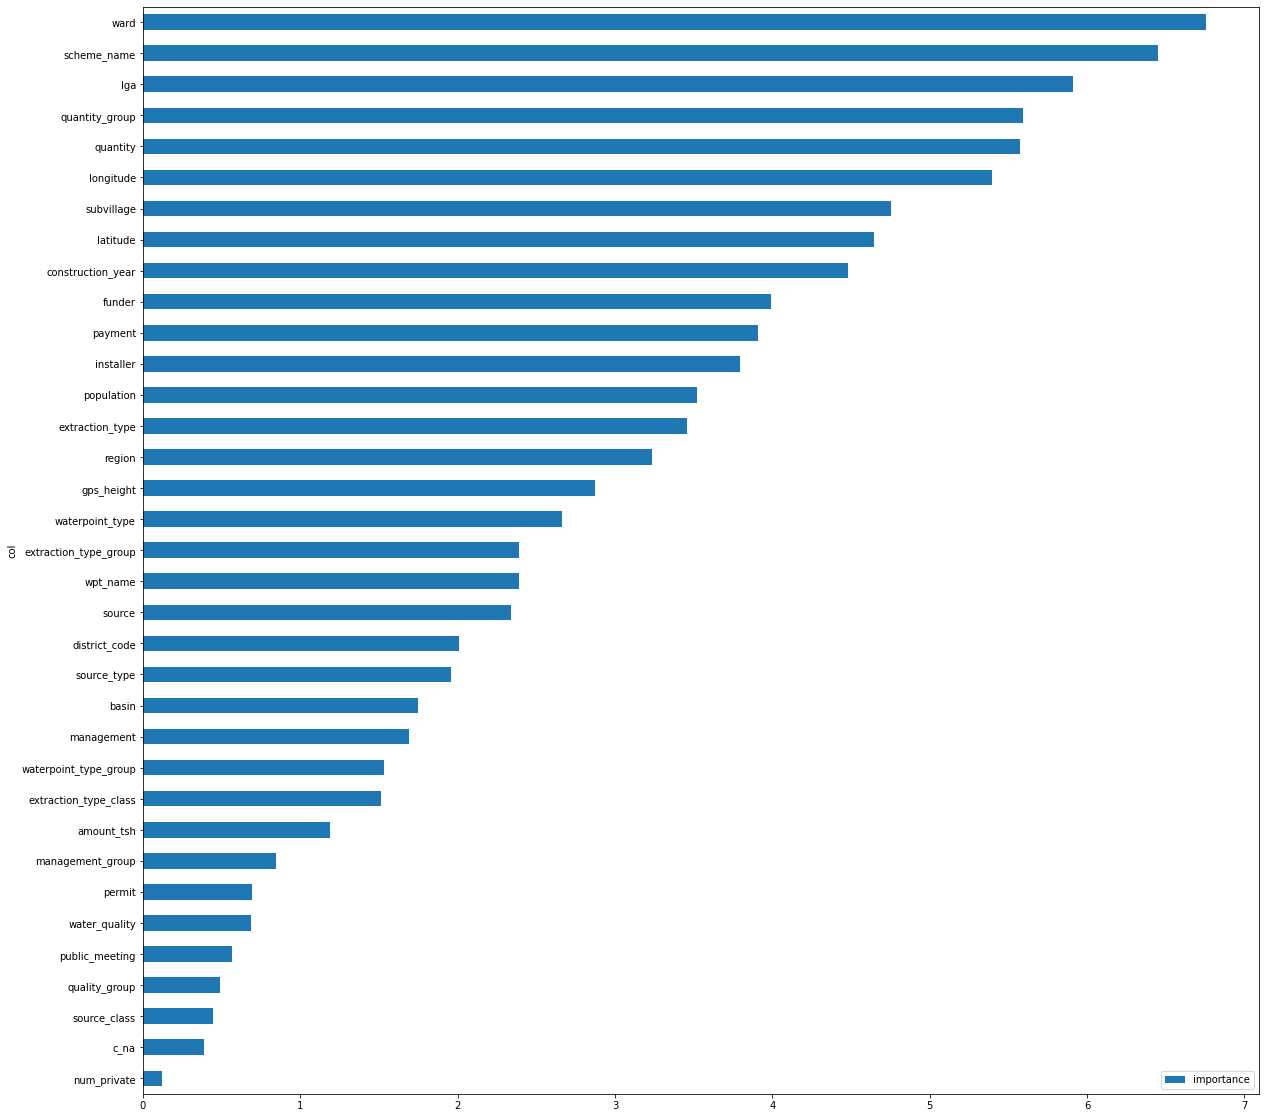

In [144]:
m = model
fea_imp = pd.DataFrame({'importance': m.feature_importances_,
                        'col': m.feature_names_})
fea_imp = fea_imp.sort_values(['importance', 'col'],
                               ascending=[True, False]).iloc[-40:]
fea_imp.plot(kind='barh', x='col', y='importance', figsize=(20, 20))

In [145]:
print(f"balanced accuracy: {balanced_accuracy_score(y_test, predictions)}")
class_rate = classification_rate(y_test, predictions[:,0])
print(f"classification rate: {class_rate}")

balanced accuracy: 0.6428567409657696
classification rate: 0.805050505050505


In [146]:
model.fit(
        df_train.drop(['status_group'], axis=1), df_train['status_group'],
        # eval_set=(X_test, y_test),
        cat_features=cat_features,
        verbose=1000,
        plot=False,
        # use_best_model=True
        )

AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 47.5ms	remaining: 7m 55s
1000:	total: 49.1s	remaining: 7m 21s
2000:	total: 1m 37s	remaining: 6m 31s
3000:	total: 2m 23s	remaining: 5m 34s
4000:	total: 3m 7s	remaining: 4m 40s
5000:	total: 3m 51s	remaining: 3m 51s
6000:	total: 4m 47s	remaining: 3m 11s
7000:	total: 5m 44s	remaining: 2m 27s
8000:	total: 6m 30s	remaining: 1m 37s
9000:	total: 7m 13s	remaining: 48.1s
9999:	total: 8m 1s	remaining: 0us


In [112]:
predictions = model.predict(df_test)

In [113]:
sub = pd.read_csv("data/SubmissionFormat.csv", index_col='id')
sub['status_group'] = predictions[:,0]
sub.to_csv(f"submissions/submission_catboost_{round(class_rate, 4)}.csv", index=True)